# TITLE: COMPARING XGBOOST, GAM, MVGAM, PROPHET, AND LSTM ON TIMESERIES DATA

#### References:
#### 1. Nicholas Clarck, "MVGAM", https://ecogambler.netlify.app/blog/autocorrelated-gams/
#### 2. Gregg Hogg, "Stock Price Prediction & Forecasting with LSTM Neural Networks in Python", https://www.youtube.com/watch?v=CbTU92pbDKw&t=1537s
#### 3. OWCZAR, "GAM Model for Time-Series Forecasting", https://www.kaggle.com/code/owczar/gam-model-for-time-series-forecasting



# Indexes: 
### 0. Libraries
### 1. The Data
### 2. Methods
### 3. generating test/train data and visualizing it
### 4. ML Models
#####      • 4.1 XGBoost 
##### • 4.2 GAMs
##### • 4.3 LSTM
##### • 4.4 Facebook Prophet
##### • 4.5 MVGAM
### 5. Comparison and Analysis

# 0.Libraries

In [5]:
import yfinance as yf

In [6]:
# from formatDF import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError as mse
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.optimizers import Adam
import numpy as np
import xgboost as xgb

In [7]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import folium
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HTML
from dash import Dash, html, dcc, callback, Output, Input

In [8]:
from sklearn.preprocessing import MinMaxScaler

# 1.The Data 
### • Backbone data of this project and the variables:
#####    - Data: S&P500 index (sp500)
#####    - Variables for training: 'quarter', 'year', 'month', 'dayofweek', 'yesterday'
#####    - Variables for testing: 'quarter', 'year', 'month', 'dayofweek'
#####    - Y (answer variable): "Close"

In [10]:
## Import sp500
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period ="max")
sp500 = sp500.iloc[(sp500.index>'28-12-1979')]

## Create a new feature called "yesterday" and drop all data with N/A 
sp500['yesterday'] = sp500.Close.shift(1)
sp500 = sp500.dropna()

In [11]:
## Understanding the features
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11325 entries, 1980-01-02 00:00:00-05:00 to 2024-12-02 00:00:00-05:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11325 non-null  float64
 1   High          11325 non-null  float64
 2   Low           11325 non-null  float64
 3   Close         11325 non-null  float64
 4   Volume        11325 non-null  int64  
 5   Dividends     11325 non-null  float64
 6   Stock Splits  11325 non-null  float64
 7   yesterday     11325 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 796.3 KB


In [12]:
## convert the Sp500 indexes to a data_time object for easier manipulation based on date and time
sp500.index = pd.to_datetime(sp500.index)    

In [13]:
## Variables 
FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek']
TARGET = 'Close'


In [14]:
## a Dictionary to save the RMSE of each method that is used
RMSE_dict = {}

# 2. Methods
### • Defining methods for processing and visualizing Data

###  • Methods for generating test/train data


In [17]:
### Used for generating empty df with indexes as dates
### If given 365 days, creates future dates, that only include weekdays.
### It's easy to imagine that it creates 365 days, then discards all the weekends.
### If today is Jan 1, 2024, it will create up to Jan 1, 2025
# input: days (int)
# output: (Pandas DataFrame object) 
def generateFutureDates(days):
    today = pd.to_datetime('today').normalize()
    
    period = days
    pred_range = pd.date_range(start = today, periods = period, freq="D")
    temp_df = pd.DataFrame(index=pred_range)
    temp_df2 = createSeasonalFeatures(temp_df)
    temp_df2 = temp_df2[temp_df2['dayofweek'] < 5]
    return temp_df2

In [18]:
## This method divides the test and train data based on the year given. 
#   input: (type pandas-dataframe, int, int, int, int) df, train_year_start, train_year_end, test_year_start, test_year_end
#   output: (type list list) test, train
def generateTrainTest(train_year_start, train_year_end, test_year_start, test_year_end=0, df=sp500):
    train_year_start = str('01-01-' + str(train_year_start))
    train_year_end = str('31-12-' + str(train_year_end))
    test_year_start = str('01-01-' + str(test_year_start))
    test_year_end = str('31-12-' + str(test_year_end))
    
    
    sp_train = df.iloc[(df.index < train_year_end)& (df.index > train_year_start)] 
    sp_test = None

    ## if no test end date specified, show full range of future dates
    if(test_year_end == 0):
        sp_test = df.iloc[df.index >= test_year_start]
    sp_test = df.iloc[(df.index <= test_year_end)& (df.index >= test_year_start)]     
    
    ## Drop data that can cause data leakage
    sp_test.drop('yesterday', axis=1)
    
    return sp_train, sp_test

In [19]:
## given a df, it adds seasonal features defined above
## new values are also generated based on the date information in the df
# Input: DF object
# Output: DF object
def createSeasonalFeatures(df):
    DF = df.copy()
    DF["quarter"] = df.index.quarter    
    DF["year"] = df.index.year
    DF["month"] = df.index.month
    DF["dayofweek"] = df.index.dayofweek
    return DF

In [20]:
# Accepts TRAIN data and returns DF of X and and DF of Y
def separateTrainXY(train_data, features, target):
    FEATURES = features
    TARGET = target
    x_train = train_data[FEATURES_TRAIN] 
    y_train = train_data[TARGET]
    return x_train, y_train

# Accepts TEST data and returns DF of X and and DF of Y
def separateTestXY(test_data, features, target):    
    FEATURES_TEST = features
    TARGET = target
    x_test = test_data[FEATURES_TEST]
    y_test = test_data[TARGET]
    return x_test, y_test

In [21]:
## given a 7 parameters, this function returns a dictionary of all the test and train data
# Input: train_start(int), train_end(int), test_start(int), test_end(int), FEATURES_TRAIN(list), FEATURES_TEST(list), TARGET(string)
# Output: dictionary object containing 6 DF objects: train, test, x_train, y_train, x_test, y_test
def getTrainTestDict(train_start, train_end, test_start, test_end, FEATURES_TRAIN, FEATURES_TEST, TARGET):
    ## Acquire training and test data
    _train_, _test_ = generateTrainTest(train_start, train_end, test_start, test_end)
    ## Add on seasonal data (quarter, month, day, etc)
    _test_ = createSeasonalFeatures(_test_)
    _train_ = createSeasonalFeatures(_train_)
    ## Separate X and y
    _x_train_, _y_train_ = separateTrainXY(_train_, FEATURES_TRAIN, TARGET)
    _x_test_, _y_test_ = separateTestXY(_test_, FEATURES_TEST, TARGET)

    dictionary = {        
        "train": _train_,
        "test": _test_,
        "x_train": _x_train_,
        "y_train":_y_train_,
        "x_test":_x_test_,
        "y_test":_y_test_
    }
    return dictionary

###  - Methods for getting RMSE score

In [23]:
## Method for score evaluation
def getRMSE(predicted, actual):
    RMSE_score = 0
    if len(predicted) != len(actual):
        print("make sure that input1(predicted) and input2(actual) have the same lengths")
    else:
        for i in range(len(predicted)):
            delta = predicted.iloc[i].prediction - actual.iloc[i].Close
            RMSE_score += delta**2

    RMSE_score = RMSE_score/len(predicted)
    RMSE_score = np.sqrt(RMSE_score)
    return RMSE_score

###  - Methods for visualizing data

In [25]:
def visualizePredictions(prediction, df):
    ax = df['Close'].plot( color = "black", label='actual')
    prediction['prediction'].plot(ax=ax, color = "purple", label='predicted')
    ax.legend()
    plt.show()

In [26]:
def visualizePredictionsArtificialInflation(prediction, df):
    incremented_predictions = prediction.copy()
    incremented_predictions['prediction'] = incremented_predictions['prediction'] + range(1, 2 * len(prediction) + 1, 2)
    ax = df['Close'].plot( color = "black", label='actual')
    incremented_predictions['prediction'].plot(ax=ax, label='prediction', color = "purple")
    ax.legend()
    plt.show()

In [27]:
# ## Original implementation of visualization based on PLOTLY, but GITHUB 
# ## can't really host file sizes this big, so the same method was reimplemented in the next block using matplotlib
# def PLTvisualize(prediction_of_df, df, save_html=False):
#     trained = prediction_of_df.iloc[(prediction_of_df.index<'01-01-2021')]
#     test = prediction_of_df.iloc[(prediction_of_df.index>'31-12-2020')]
    
#     trace = px.line(data_frame = trained, y = 'prediction', color_discrete_sequence=['red'])
#     trace.data[0].name = "predicted(train)"    
    
#     trace2 = px.line(data_frame = test, y = 'prediction', color_discrete_sequence=['purple'])
#     trace2.data[0].name = "predicted(test)"    
    
    
#     fig = px.line(data_frame = df, y = 'Close', color_discrete_sequence=['black'])
#     fig.data[0].name = "Actual Price"
#     fig.add_trace(trace.data[0])
#     fig.add_trace(trace2.data[0])



#     fig.update_traces(name='Actual Close', selector=dict(name='y'))
#     fig.data[1].name = 'Predicted Price(train)'
#     fig.data[2].name = 'Predicted Price(test)'
#     fig.data[0].showlegend = True
#     fig.data[1].showlegend = True
#     fig.data[2].showlegend = True
    


#     fig.update_layout(
#         height=600,
#         width=1000,
#         title='S&P 500 Actual vs Predicted Close Prices',
#         xaxis=dict(tickangle=-90),
#         legend_title='Legend',
#         font=dict(size=18)
#     )

#     fig.show()
    
#     if save_html:
#         ## function for creating html file for this plot
#         fig.write_html('model_test.html')
    

In [28]:
def PLTvisualize(prediction_of_df, df):
    trained = prediction_of_df.loc[prediction_of_df.index < '2021-01-01']
    test = prediction_of_df.loc[prediction_of_df.index > '2020-12-31']
    plt.figure(figsize=(12, 6))
    
    plt.plot(df.index, df['Close'], color='black', label='Actual Price')
    plt.plot(trained.index, trained['prediction'], color='red', label='Predicted Price (Train)')
    plt.plot(test.index, test['prediction'], color='purple', label='Predicted Price (Test)')
    
    # labels
    plt.title('S&P 500 Actual vs Predicted Close Prices', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    

    plt.xticks(rotation=90)
    plt.legend(title='Legend', fontsize=12)
    plt.tight_layout()
    plt.show()

# 3. generating test/train data and visualizing it

#####   NOTE • Range of data for train data [1980-2020]   • Range of data for test data [2021-2024]

In [31]:
data = getTrainTestDict(1980, 2020, 2021,2024, FEATURES_TRAIN, FEATURES_TEST, TARGET)

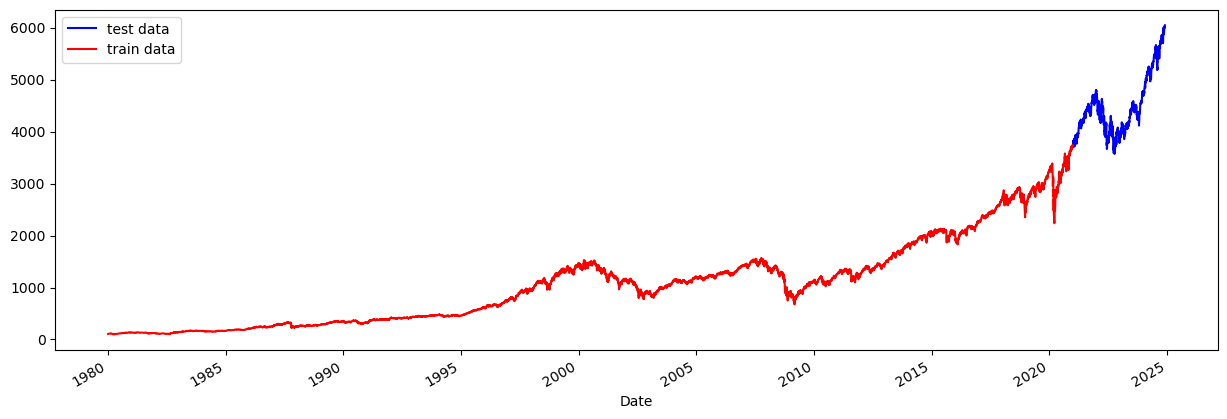

In [32]:
## Visualize Training Data(red) and Testing Data(blue)
fig, ax = plt.subplots(figsize = (15,5))
data['test'].Close.plot(ax = ax, label="test data", color = "blue")
data['train'].Close.plot(ax = ax, label="train data", color = "red")
ax.legend()

# 4. Model Testing

# 4.1: XGBoost
# INTRO: 
### - XGBoost is a great timeseries model as it was designed to work with a large set of data
### - I used this model over the summer for stock prediction, and I discovered data leakage due to multiple dataframe copying without the use of the .copy() function. https://danielgitcontribute.ca/stock.html
### - In this project, the data leakage has been removed, and .copy() is used more rigorously.

### • automate prediction, fit model, and train model

In [36]:
def modelPredict(model_, train, test, x_test):
    x_test_ = x_test.copy()
    last_close_price = train.iloc[-1].Close

    ## DataFrame to store predictions
    predictions = []

    
    ## Predict day by day
    for i in range(len(x_test_)):
        current_features = x_test_.iloc[[i]].copy()
        
        current_features["yesterday"] = last_close_price


        ## Predict stock price for the current day
        predicted = model_.predict(current_features)
        
        ## temp add to add date exp
        # predicted *
        predictions.append(predicted)
        last_close_price = predicted
    

    pred_list = []
    for i, element in enumerate(predictions):
        pred_list.append(element[0])
    
    x_test_['prediction'] = pred_list
        
    return x_test_


In [37]:
model_xgb = xgb.XGBRegressor(n_estimators=3000, learning_rate = 0.02, max_depth=10)
model_xgb.fit(data['x_train'], data['y_train'], 
           verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
pd.DataFrame(data = model_xgb.feature_importances_,
            index = FEATURES_TRAIN,
            columns = ["importance"])

importance
quarter      0.000093
year         0.059484
month        0.000108
dayofweek    0.000073
yesterday    0.940241

In [39]:
predictions1 = modelPredict(model_xgb, data['train'], data['test'], data['x_test'])

### • Visualization & Evaluate

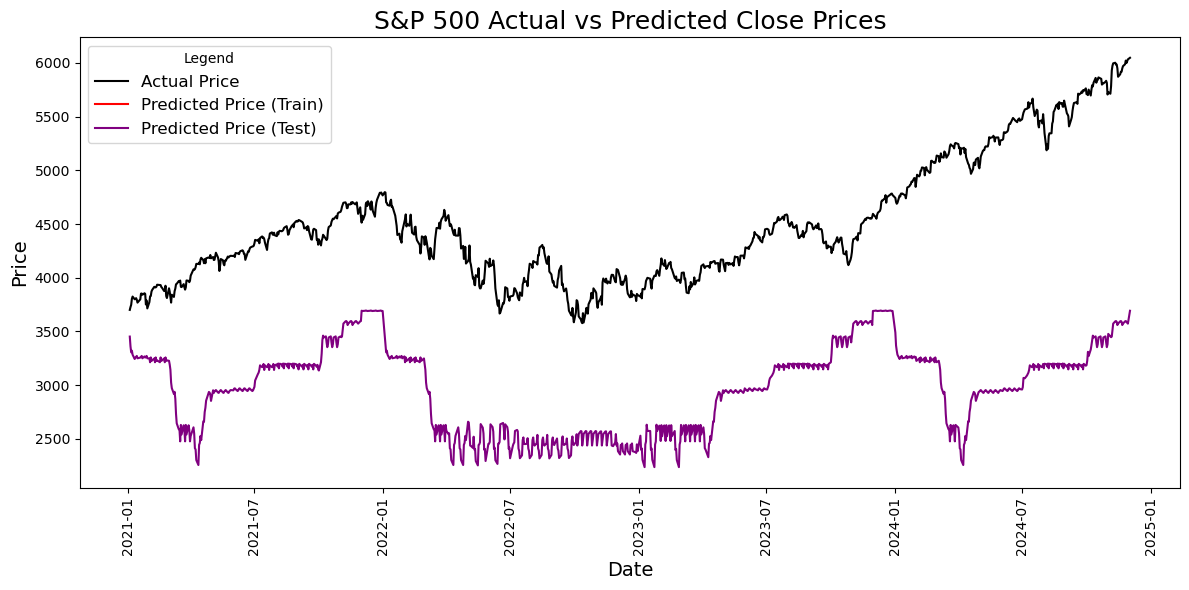

In [41]:
PLTvisualize(predictions1, data['test'])

In [42]:
RMSE = getRMSE(predictions1, data['test']) 
print("RMSE XGBoost:", RMSE)

RMSE XGBoost: 1600.581887751145


In [43]:
## save RMSE score for comparison 
RMSE_dict['XGB'] = RMSE

### Figure shows that XGBoost is fairly good at finding seasonal trends, but it is not great at learning a slope. Let's try artificially uniformily increase the prediction values.

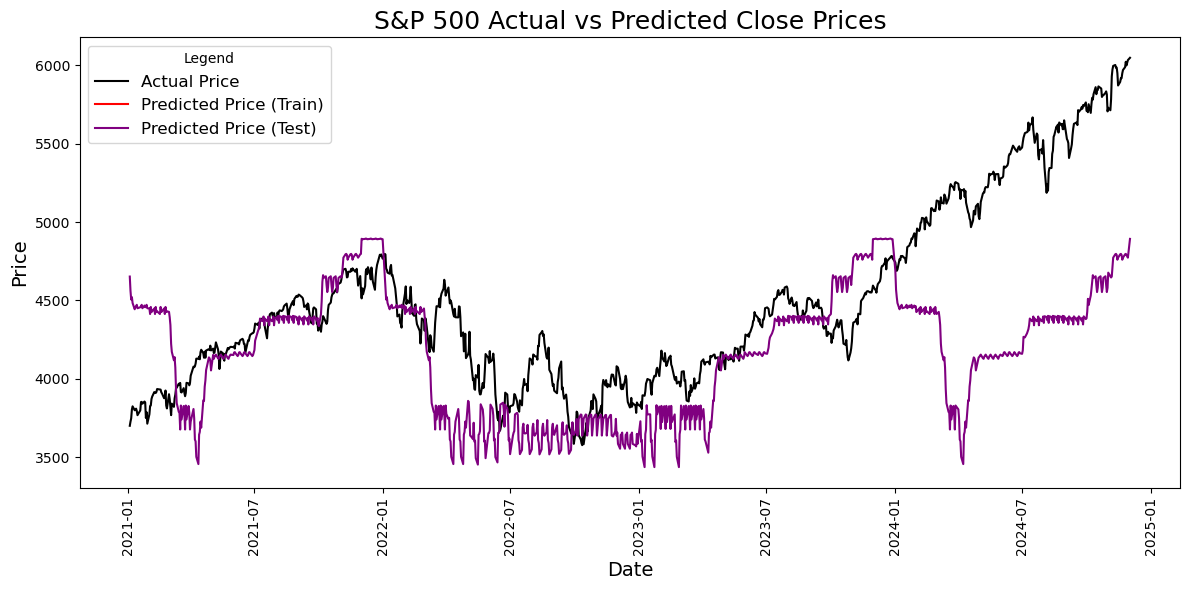

In [45]:
predictions_inflated = predictions1.copy()
predictions_inflated['prediction'] = predictions_inflated['prediction'] + 1200 
PLTvisualize(predictions_inflated, data['test'])

In [46]:
RMSE_inflated = getRMSE(predictions_inflated, data['test']) 
print("RMSE XGBoost:", RMSE_inflated)

RMSE XGBoost: 604.3003011449805


### • Verdict: XGBoost somehow learns seasonal information very good, but fails to account for inflation, or a growing trend.

### • Let's Visualize all that we have learned so far and add some more interpretability metrics

In [49]:
## Get the Numpy array of predictions for x_train
train_prediction = model_xgb.predict(data['x_train'])
## Add the prediction to a df skeleton
train_prediction_df = data['x_train'].copy()
train_prediction_df['prediction'] = train_prediction

In [50]:
train_and_test_prediction = pd.concat([train_prediction_df, predictions1], axis=0)

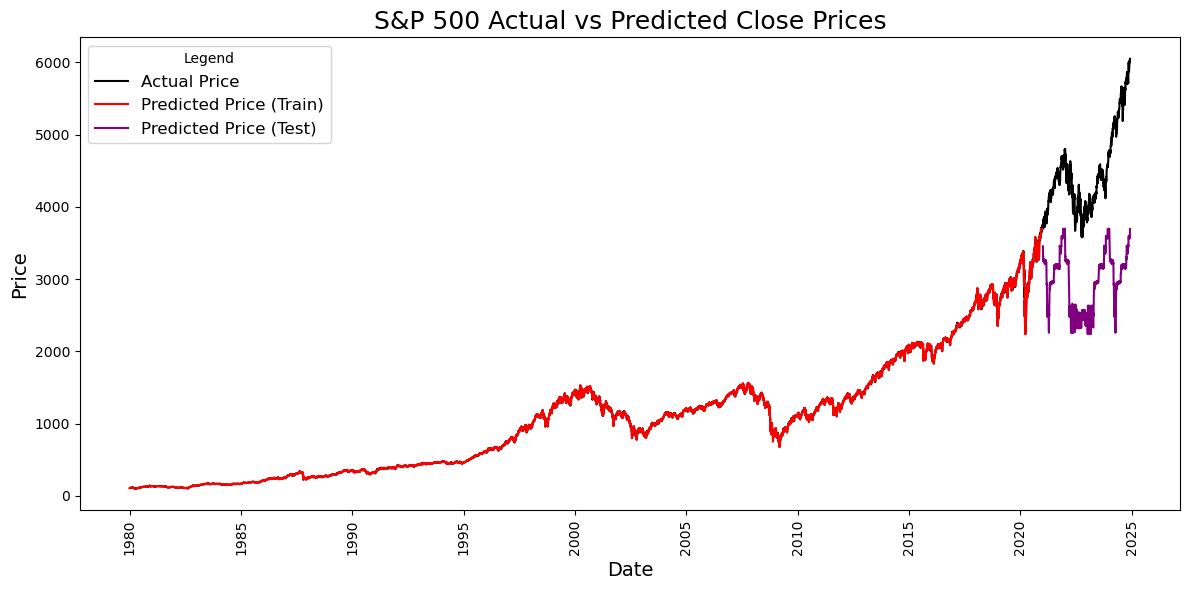

In [51]:
PLTvisualize(train_and_test_prediction, sp500)

In [52]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(data['x_train'])

### Looks like SHAP didn't like the n_value_estimators being too big (n_estimator = 3000).
### Re-attempting to run with a more managable size, 500

In [54]:
dummy_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate = 0.02, max_depth=10)
dummy_xgb.fit(data['x_train'], data['y_train'], 
           verbose = True)
explainer = shap.Explainer(dummy_xgb)
shap_values = explainer(data['x_train'])

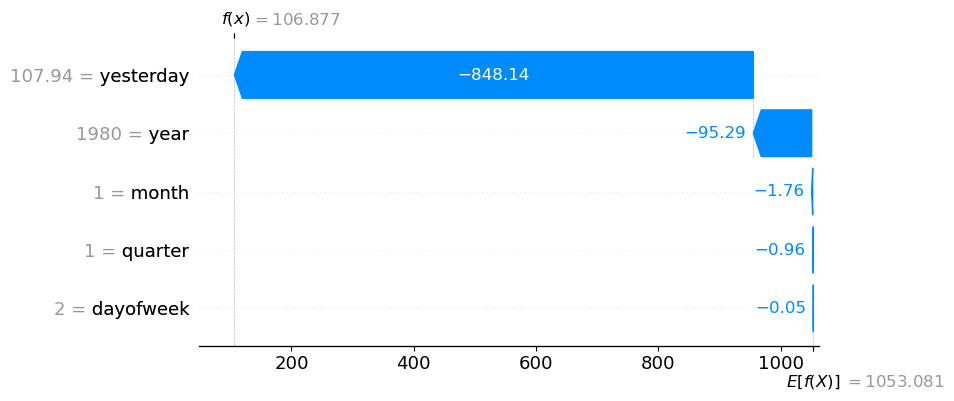

In [55]:
shap.plots.waterfall(shap_values[0])

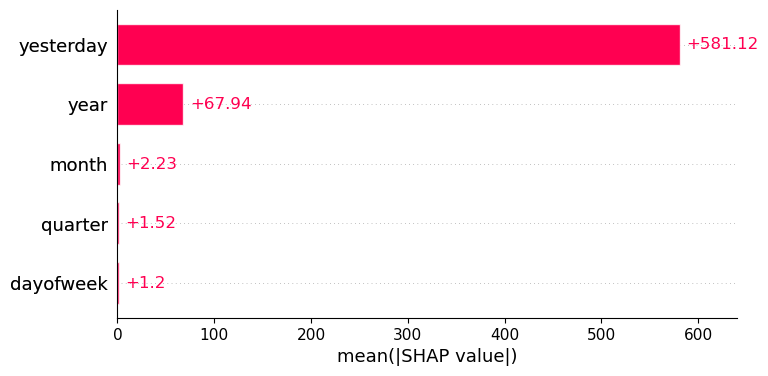

In [56]:
shap.plots.bar(shap_values)

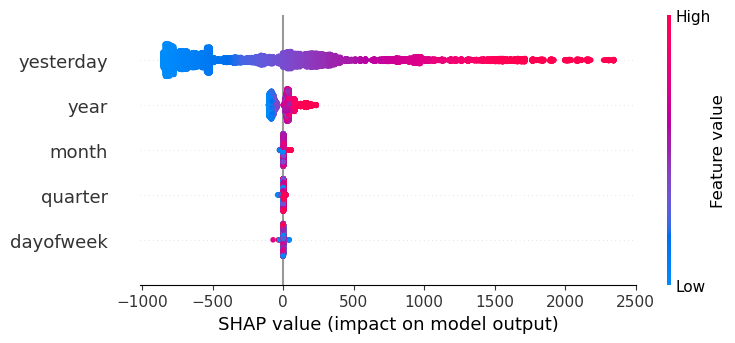

In [57]:
shap.plots.beeswarm(shap_values)

# 4.2 GAMs
# Intro: 
### - one of the advanced AI method learned in the course
### - selected for this project for its interpretability
### - find out if GAM works on time series


### • import GAM, define the GAM model, and automate GAM prediction

In [60]:
from pygam import GAM, s, te

In [61]:
data['x_test']

quarter  year  month  dayofweek
Date                                                      
2021-01-04 00:00:00-05:00        1  2021      1          0
2021-01-05 00:00:00-05:00        1  2021      1          1
2021-01-06 00:00:00-05:00        1  2021      1          2
2021-01-07 00:00:00-05:00        1  2021      1          3
2021-01-08 00:00:00-05:00        1  2021      1          4
...                            ...   ...    ...        ...
2024-11-25 00:00:00-05:00        4  2024     11          0
2024-11-26 00:00:00-05:00        4  2024     11          1
2024-11-27 00:00:00-05:00        4  2024     11          2
2024-11-29 00:00:00-05:00        4  2024     11          4
2024-12-02 00:00:00-05:00        4  2024     12          0

[985 rows x 4 columns]

In [62]:
def runGAM(gam):
    temp_train = data['x_train'].copy()
    temp_train = temp_train.drop('yesterday', axis=1)
    gam.fit(temp_train, data['y_train'])
    predictions_gam = gam.predict(data['x_test'])
    predictions_gam_df = data['x_test'].copy()
    predictions_gam_df['prediction'] = predictions_gam
    RMSE = getRMSE(predictions_gam_df, data['test']) 
    print("RMSE XGBoost:", RMSE)
    
    dummy = data['x_train'].copy()
    dummy = dummy.drop('yesterday', axis=1)
    predictions_gam_dummy = gam.predict(dummy)
    
    predictions_gam_dummy_df = data['x_train'].copy()
    predictions_gam_dummy_df['prediction'] = predictions_gam_dummy
    predictions_gam_dummy_df = predictions_gam_dummy_df.drop('yesterday', axis=1)
    df_rows = pd.concat([predictions_gam_dummy_df, predictions_gam_df], axis=0)
    PLTvisualize(df_rows, sp500)

In [63]:
##  s(0): quarter
##  s(1): year
##  s(2): month
##  s(3): day of week
##  te(0,3): quarter & day of week interaction term
gam = GAM(s(0) + s(1) + s(2) + s(3) + te(0,3))

RMSE XGBoost: 780.7367780632711


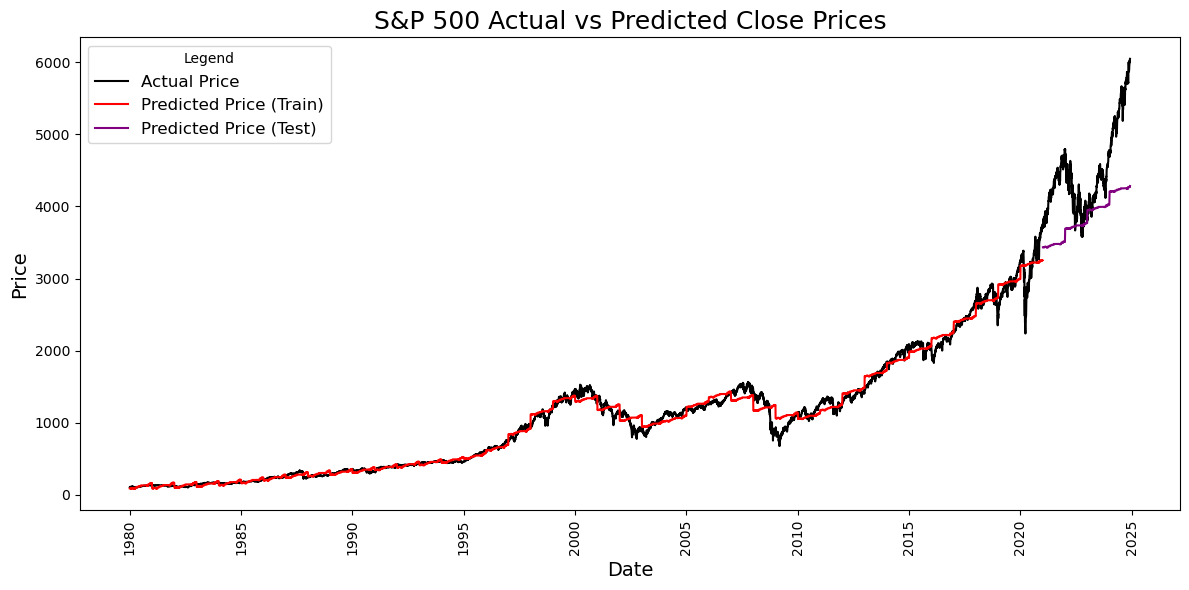

In [64]:
## Running GAM with all the terms
runGAM(gam)

RMSE XGBoost: 3486.1698182523883


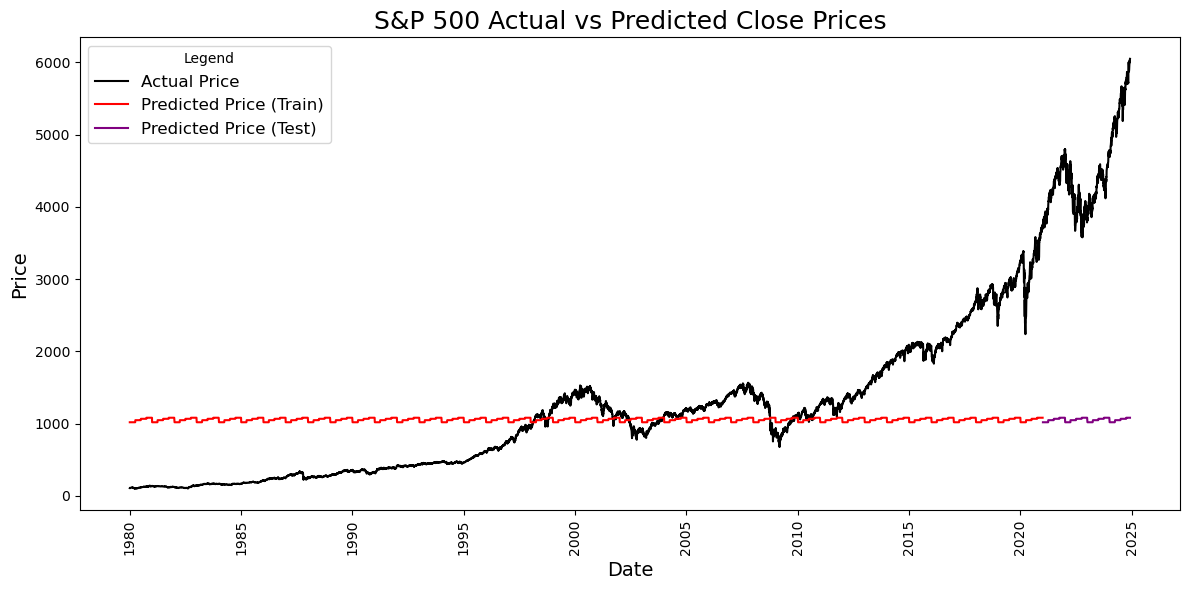

In [65]:
## Gam trained with just "quarter"
gam2 = GAM(s(0))
runGAM(gam2)

RMSE XGBoost: 783.2417813768392


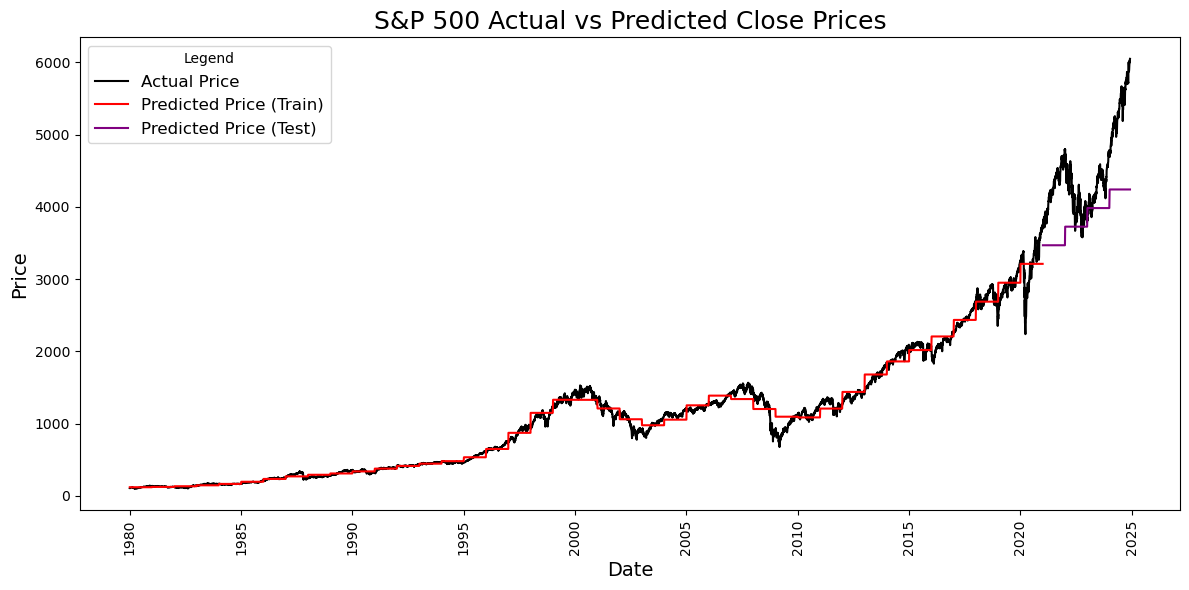

In [66]:
## Gam trained with just "year"
gam3 = GAM(s(1))
runGAM(gam3)

RMSE XGBoost: 3486.3453320464237


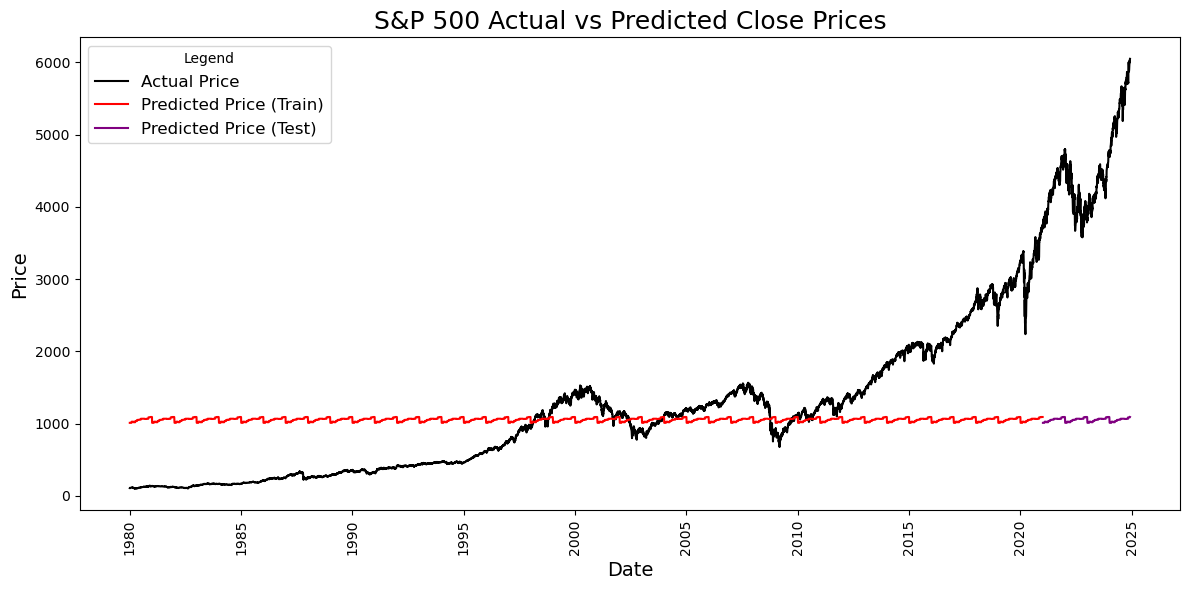

In [67]:
## Gam trained with just "month"
gam4 = GAM(s(2))
runGAM(gam4)

RMSE XGBoost: 3486.302609453141


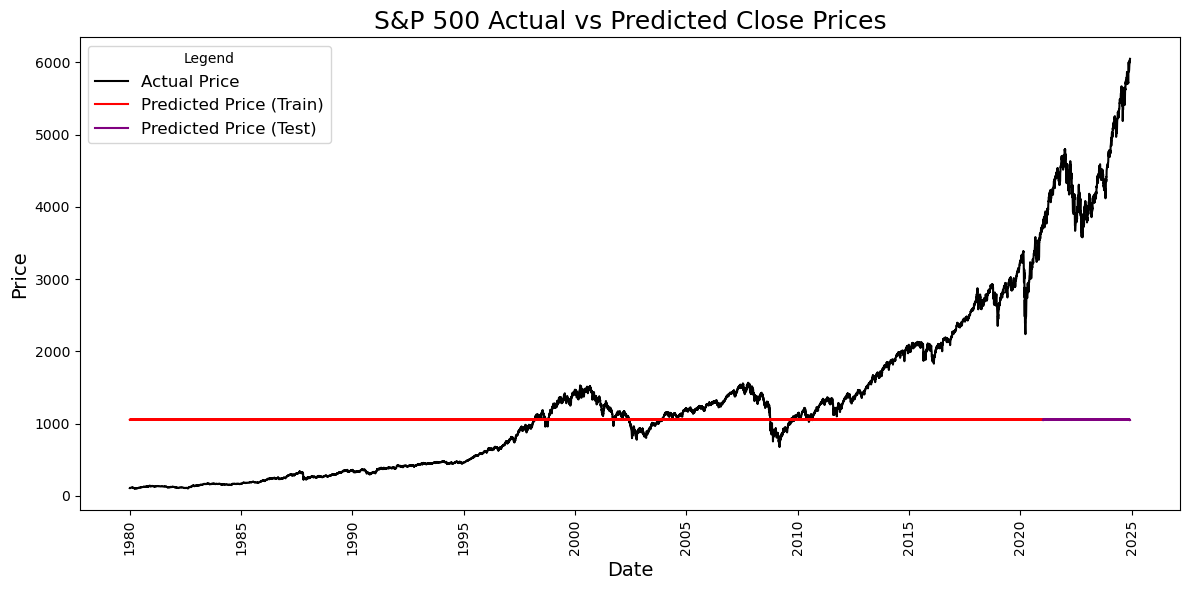

In [68]:
## Gam trained with just "day-of-week"
gam5 = GAM(s(3))
runGAM(gam5)

### • gam5 seems like it didn't learn a trend, but try inspecting with a zoom in. The the term "day-of-week" enables GAMs to learn the highest and lowest price during the week. Monday generally reporting the lowest stock price and Friday being the highest. This is generally true in my past 7 years of stock trading.

RMSE XGBoost: 787.1616706202002


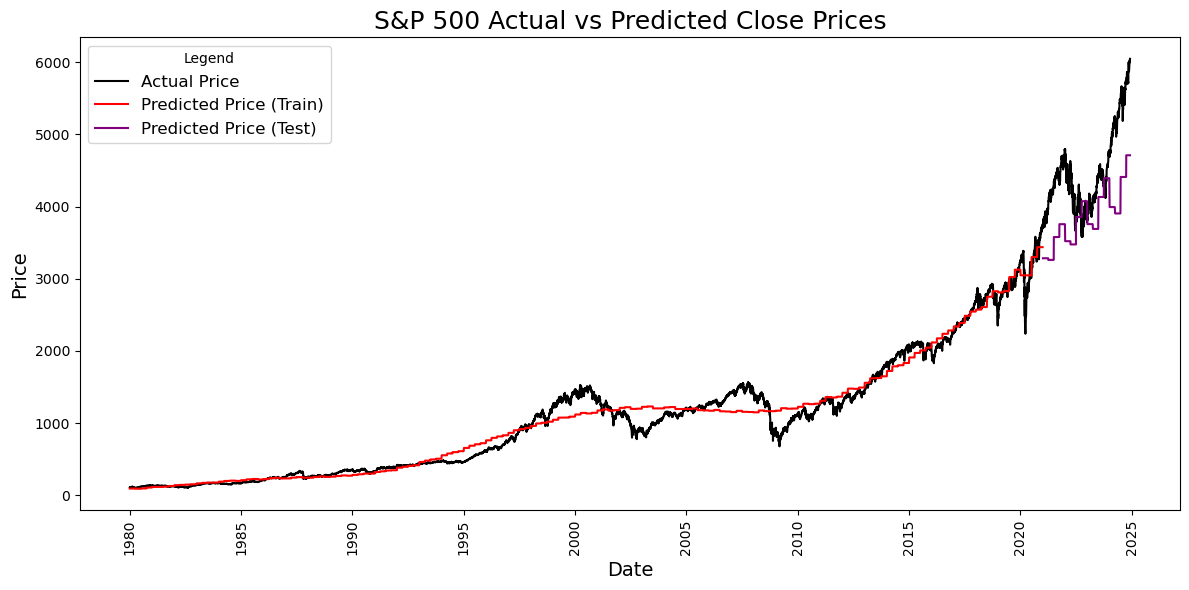

In [70]:
## Gam trained with just "a single interaction term"
gam6 = GAM(te(0,1))
runGAM(gam6)

In [71]:
## Save this RMSE score 
RMSE_dict['GAM'] = 786.408

RMSE XGBoost: 825.0410109445025


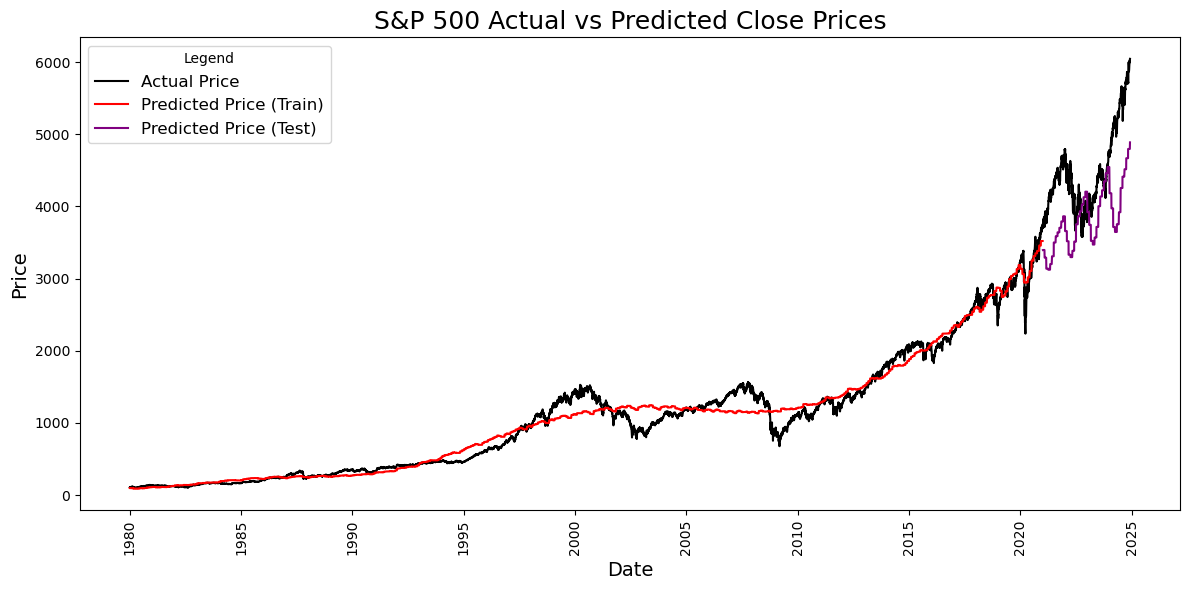

In [72]:
## Now I'm just experimenting to see if adding multiple interactions (increasing complexity) will produce a better result
gam7 = GAM(te(1,2) + te(0,2) + te(0,1) + te(0,1,2) + s(3))
runGAM(gam7)

## Review of GAM: 
##### • GAMs proves to be a great tool for interpretability. It shows exactly what each term learns. Adding interaction terms starts emulating real life data, which shows how complex real life data is. 
##### • Even by just providing "year" as the parameter, it is incredible how much the model can learn (refer to gam3).

# 4.3 LSTM

# INTRO/Explanation
### • This section has some additional steps due to the following added complexities
#### 1) lag features
#### 2) validation data (a partition of the test data as it still falls under the date range of the test data)

#### • Recreate the DF anew, just to be on the safe from data leakage.

In [78]:
lstm_train, lstm_test = generateTrainTest(1980,2020,2021,2024)

lstm_train = createSeasonalFeatures(lstm_train)
lstm_test = createSeasonalFeatures(lstm_test)

lstm_train = lstm_train[['quarter', 'year', 'month', 'dayofweek', 'Close']]
lstm_test = lstm_test[['quarter', 'year', 'month', 'dayofweek', 'Close']]

lstm_train.index = lstm_train.index.strftime('%Y-%m-%d')
lstm_test.index = lstm_test.index.strftime('%Y-%m-%d')

In [79]:
## Some data regularization
lstm_train.year = lstm_train.year/10
lstm_test.year = lstm_test.year/10

#### • Generate lag feature of 100. The length of the lag feature is called window_size, which will be used for additional calculation for the 4.3 block.

In [81]:
window_size = 100

In [82]:
def df_to_X_y(df, window_size=100):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][4]
    y.append(label)
  return np.array(X), np.array(y)

#### • Create train, validation, and test data

In [84]:
lstm_X_train, lstm_y_train =  df_to_X_y(lstm_train, window_size)
lstm_X_test, lstm_y_test =  df_to_X_y(lstm_test, window_size)
lstm_train_date, lstm_test_date = lstm_train.index.to_numpy(), lstm_test.index.to_numpy()


## [:,:,4] is the index where previous close prices reside. 
## Prevent data leak by masking this index to 0
lstm_X_test[:,:,4] = 0

In [85]:
lstm_X_train.shape, lstm_y_train.shape, lstm_X_test.shape, lstm_y_test.shape, lstm_train_date.shape

((10239, 100, 5), (10239,), (885, 100, 5), (885,), (10339,))

In [86]:
lstm_train_date.shape

(10339,)

In [87]:
dates_val, lstm_X_val, lstm_y_val = lstm_train_date[9500:], lstm_X_train[9500:], lstm_y_train[9500:]
dates_train, lstm_X_train, lstm_y_train = lstm_train_date[:9500], lstm_X_train[:9500], lstm_y_train[:9500]

In [88]:
lstm_X_val.shape, lstm_y_val.shape, lstm_X_train.shape, lstm_y_train.shape, dates_val.shape, dates_train.shape

((739, 100, 5), (739,), (9500, 100, 5), (9500,), (839,), (9500,))

#### • MODEL defining and training

In [90]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
lstm_model.add(Dense(16, 'relu'))
lstm_model.add(Dense(16, 'relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss=mse(), optimizer=Adam(learning_rate=0.0001), metrics=[rmse()])
lstm_model.summary()

/Users/danieljoh/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,249 (75.19 KB)

 Trainable params: 19,249 (75.19 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
lstm_model.fit(lstm_X_train, lstm_y_train, validation_data=(lstm_X_val, lstm_y_val), epochs = 100)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 1217714.2500 - root_mean_squared_error: 1103.3445 - val_loss: 9042925.0000 - val_root_mean_squared_error: 2975.1973
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1251738.5000 - root_mean_squared_error: 1118.6962 - val_loss: 9016237.0000 - val_root_mean_squared_error: 2970.7041
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1200727.0000 - root_mean_squared_error: 1095.6698 - val_loss: 8962536.0000 - val_root_mean_squared_error: 2961.5852
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1187954.2500 - root_mean_squared_error: 1089.8760 - val_loss: 8880511.0000 - val_root_mean_squared_error: 2947.6301
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1186463.8750 - root_mean_squared_error: 1089.1779 - val_loss: 8752181.0000 - val_root_mean_squared_error: 2925.6807
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1111571.7500 - root_mean_squared_error: 1054.270

#### • Perform Predict on Train Data. Then append predictions in a DF for visualization. Then visualize.

In [93]:
lstm_predictions = lstm_model.predict(lstm_X_train)
df_prediction =  data['train'].copy()

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [94]:
difference_in_len = abs(len(lstm_predictions) - len(df_prediction))
index_window = difference_in_len - window_size
df_prediction = df_prediction.iloc[window_size:-index_window]

In [95]:
df_prediction['prediction'] = lstm_predictions.flatten()
df_prediction['prediction'] = df_prediction['prediction']

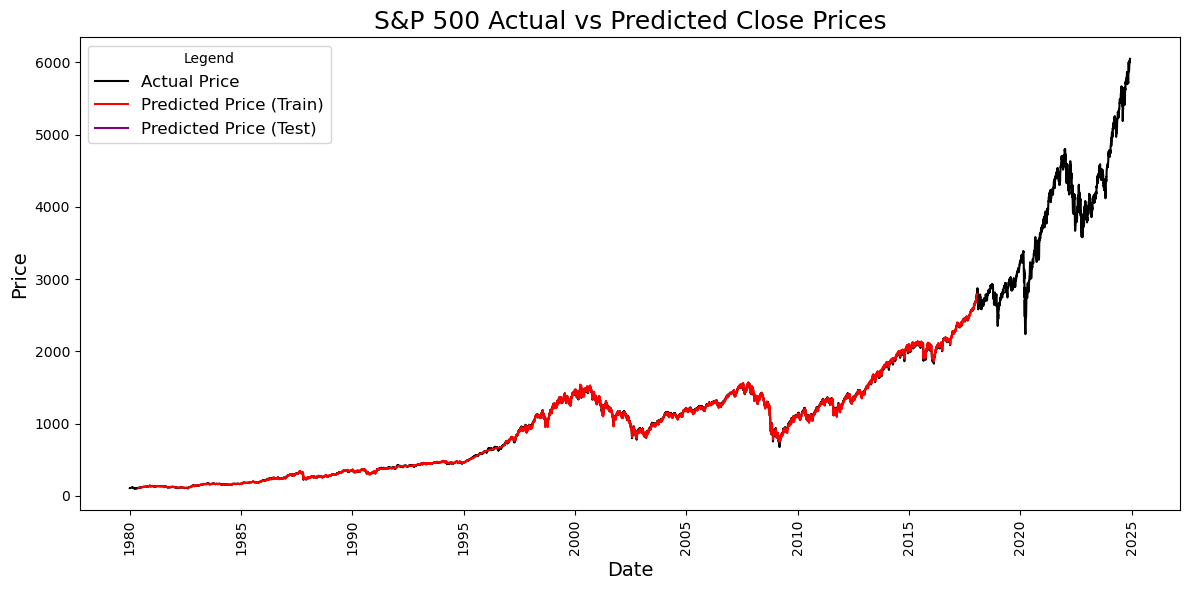

In [96]:
PLTvisualize(df_prediction,sp500)

#### • Perform Predict on Test Data. Then append predictions in a DF for visualization. Then visualize.

In [98]:
## testing on test data
lstm_predictions = lstm_model.predict(lstm_X_test)
df_prediction =  data['test'].copy()
df_prediction = df_prediction.iloc[:-window_size]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [99]:
df_prediction['prediction'] = lstm_predictions.flatten()
df_prediction['prediction'] = df_prediction['prediction']

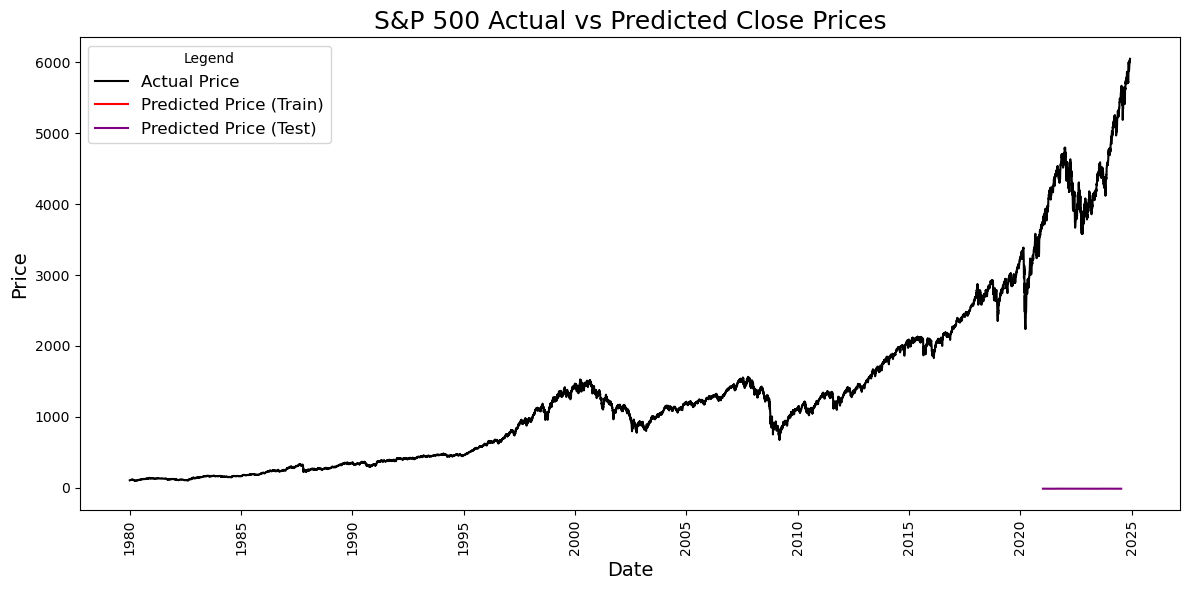

In [100]:
PLTvisualize(df_prediction,sp500)

#### • Merge test and train data
#### • Perform Predict on Merged Data. Then append predictions in a DF for visualization. Then visualize.

In [102]:
merged_array = np.concatenate((lstm_X_train, lstm_X_val, lstm_X_test), axis=0)
lstm_predictions = lstm_model.predict(merged_array)

348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [145]:
sp500_pred = sp500.copy()
sp500_pred = sp500_pred.iloc[window_size:-window_size-1]
sp500_pred['prediction'] = lstm_predictions

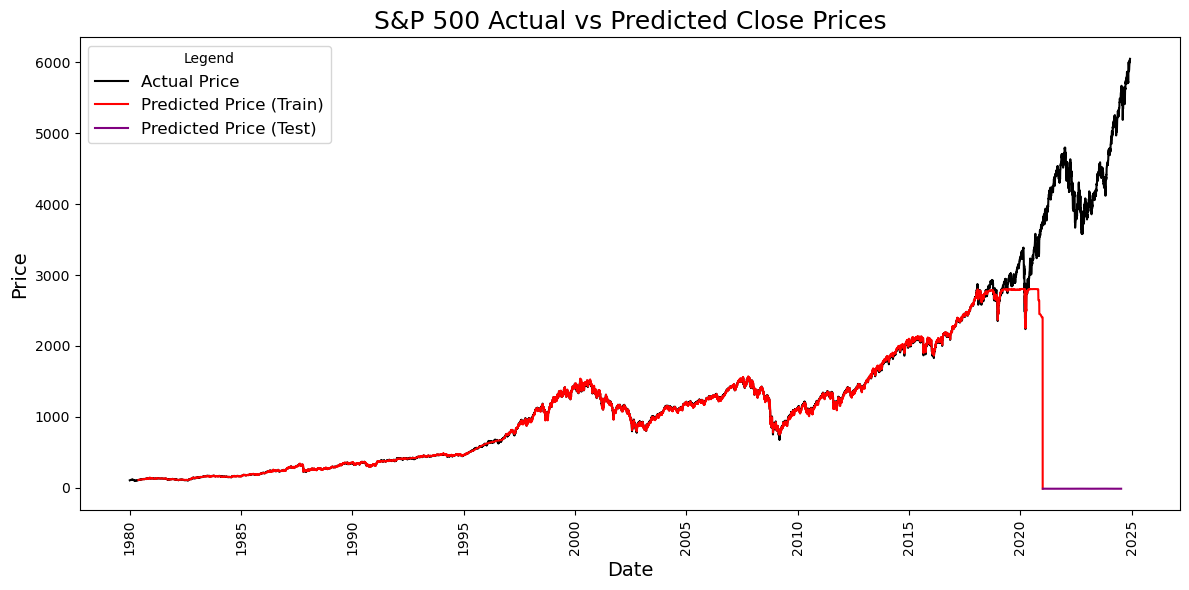

In [147]:
PLTvisualize(sp500_pred,sp500)

### • The trailing red, the part where the red data starts losing performance is the validation data. This data had all the lag features. The test data had most lag features, but historical stock prices were masked.

#### • processing results and setting data range 2020 - current (test data range) to get the RMSE

In [152]:
sp500_pred_ = sp500_pred.iloc[sp500_pred.index > '2020-12-31']
date_end = sp500_pred_.index[-1]
actual_price = data['test'].iloc[data['test'].index <= date_end]
lstm_RMSE = getRMSE(sp500_pred_, actual_price)
RMSE_dict['LSTM'] = lstm_RMSE
print("LSTM RMSE:", lstm_RMSE)

LSTM RMSE: 4388.920497973041


## Review of LSTM: 
##### • LSTM performed terribly and had no ability to learn because the test data was not given a lag features. 
##### • All the other seasonal features were given as a lag feature. The T-1 ~ T-100 lag features were masked. 
##### • LSTM would've been able to generate some sensible data for 100 days into the future had I not masked the lag feature of previous stock "close price". However, even this data would've been very inaccurate since even the validation data, which has all T-1 ~ T-100 of the previous close price, didn't perform too well.
##### • Lesson: LSTM does not learn anything without lag feature in the pipeline.

## 4.4 Facebook Prophet

### • Model made by Facebook in 2007, built upon GAMs
### • Facebook Prophet requires a different looking dataFrame.
### • DF must have 2 columns: 'ds' (data object) and 'y'
### • A test DF does not have to be pre-defined as Prophet has a built-in function that generates its own test DF with only dates 

In [159]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

#### • Format train DF to satisfy Prophet's needs

In [163]:
## Process data to be used in Prophet
train = data['train'].copy()
train["y"] = train.pop("Close")
train.insert(0, 'ds', train.index)
FEATURES_TO_DEL = ["Open", "High", "Low", "Volume", "Dividends", "Stock Splits","yesterday", "quarter", "year", "month", "dayofweek"]
for i, element in enumerate(FEATURES_TO_DEL):
    train.pop(element)
train = train.reset_index(drop=True)
train['ds'] = train['ds'].dt.strftime('%Y-%m-%d')

In [165]:
prophet = Prophet()
prophet.fit(train)

20:01:43 - cmdstanpy - INFO - Chain [1] start processing
20:01:46 - cmdstanpy - INFO - Chain [1] done processing


#### • Prophet's built in test data generation

In [168]:
future = prophet.make_future_dataframe(periods=1460)

#### • get rid of dates that are on the weekend

In [172]:
future['day_of_week'] = future['ds'].dt.dayofweek
future_weekdays = future[future['day_of_week'] < 5]
future_weekdays = future_weekdays.drop('day_of_week', axis = 1)
prophet_predictions = prophet.predict(future_weekdays)

#### • Data prediction and visualization

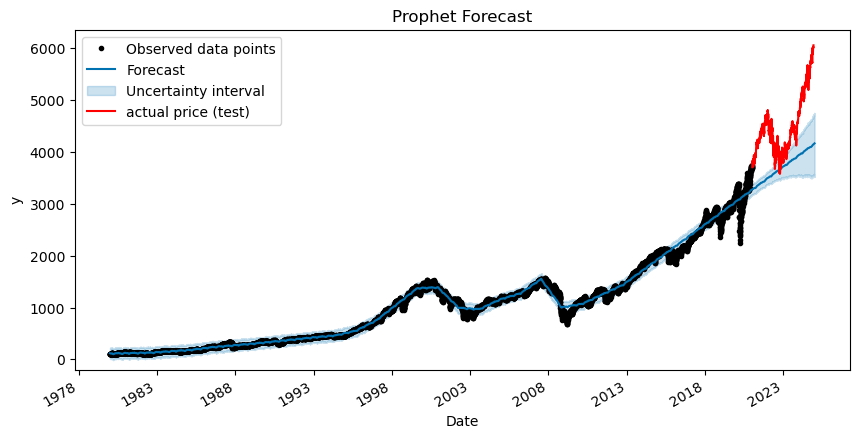

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = prophet.plot(prophet_predictions, ax=ax)
ax.set_title('Prophet Forecast')
data['test'].Close.plot(ax = ax, label="actual price (test)", color = "red")
ax.legend()
plt.show()

#### • At first hand look, prophet seems to be good at extrapolation, but it's more on the underfitting side.

#### • Process to get the RMSE value

In [182]:
len(prophet_predictions), len(data['test'])

(11381, 985)

In [184]:
prophet_rsme_df = prophet_predictions.copy()
prophet_rsme_df = prophet_rsme_df[prophet_rsme_df.ds > '2020-12-31']
diff = len(prophet_rsme_df) - len(data['test'])
prophet_rsme_df = prophet_rsme_df[:-diff]
prophet_rsme_df['prediction'] = prophet_rsme_df['yhat']
prophet_rmse = getRMSE(prophet_rsme_df, data['test'])

In [186]:
prophet_rmse

919.3545248213126

In [188]:
RMSE_dict['prophet'] = prophet_rmse

In [190]:
#### • Process to get the RMSE value

#### • The example above shows data right after the nadir of covid. What would happen if the training data ends at a down trend? Say March 2019, during covid?

In [194]:
data3 = getTrainTestDict(1980, 2020, 2020, 2024, FEATURES_TRAIN, FEATURES_TEST, TARGET)
## Process data to be used in Prophet

## Cherry pick a time when stock was dipping
train = data3['train'].copy()
train = train.iloc[:-200]

train["y"] = train.pop("Close")
train.insert(0, 'ds', train.index)
FEATURES_TO_DEL = ["Open", "High", "Low", "Volume", "Dividends", "Stock Splits","yesterday", "quarter", "year", "month", "dayofweek"]
for i, element in enumerate(FEATURES_TO_DEL):
    train.pop(element)
train = train.reset_index(drop=True)
train['ds'] = train['ds'].dt.strftime('%Y-%m-%d')

In [196]:
prophet2 = Prophet()
prophet2.fit(train)

20:01:58 - cmdstanpy - INFO - Chain [1] start processing
20:02:00 - cmdstanpy - INFO - Chain [1] done processing


In [197]:
future2 = prophet2.make_future_dataframe(periods=1760)
future2['day_of_week'] = future2['ds'].dt.dayofweek
future_weekdays = future2[future2['day_of_week'] < 5]
future_weekdays = future_weekdays.drop('day_of_week', axis = 1)
prophet_predictions2 = prophet2.predict(future_weekdays)

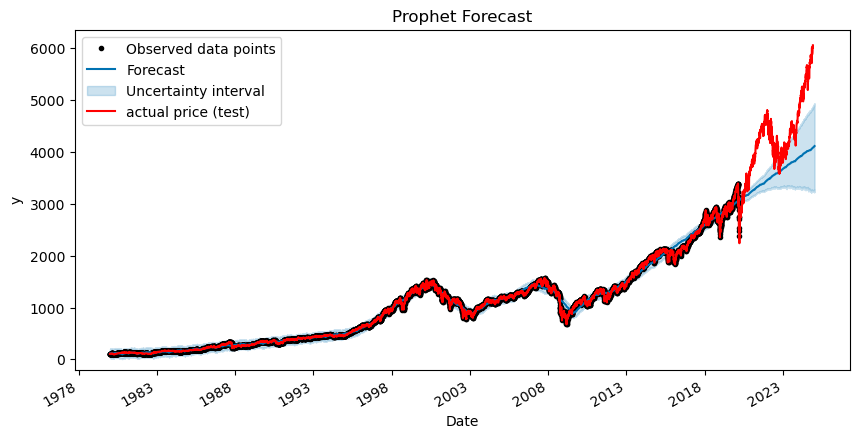

In [198]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = prophet2.plot(prophet_predictions2, ax=ax)
ax.set_title('Prophet Forecast')
sp500.Close.plot(ax = ax, label="actual price (test)", color = "red")
ax.legend()
plt.show()

In [199]:
prophet_rsme_df = prophet_predictions2.copy()
prophet_rsme_df = prophet_rsme_df[prophet_rsme_df.ds > '2020-12-31']
diff = len(prophet_rsme_df) - len(data['test'])
prophet_rsme_df = prophet_rsme_df[:-diff]
prophet_rsme_df['prediction'] = prophet_rsme_df['yhat']
prophet_rmse2 = getRMSE(prophet_rsme_df, data['test'])
prophet_rmse2

959.0405775355907

### • Ending the training at a downtrend did decrease the RMSE, but not by too much. More evidence that the model underfits more to a rigid line.

# 4.5 MVGAM

# Intro:
### • MVGAM is a method created in late 2023, and the library only exists in R. Please refer to 'predictor_R.ipynb' for implementation details
### • Some of the visualization and data processing in R are direct copies of the creator of the library, Nicholas Clark. (link https://ecogambler.netlify.app/blog/autocorrelated-gams/)
### • In this block, most of the data is handled over in R. 
### • First data is processed and exported to mvgam.ipynb, which runs on R. 
### • Then, the findings are exported back to this file in this same block. Look out for the comments.

### • Preparing to export train and test data for R

In [213]:
output = data['train'].copy()

In [215]:
output = data['train'].copy()
output = output[["Close"]]
output["count"] = output['Close']
output = output.drop(columns={"Close"})
output = output.reset_index(drop = True)
output['time'] = output.index+1
output

count   time
0       105.760002      1
1       105.220001      2
2       106.519997      3
3       106.809998      4
4       108.949997      5
...            ...    ...
10334  3690.010010  10335
10335  3703.060059  10336
10336  3735.360107  10337
10337  3727.040039  10338
10338  3732.040039  10339

[10339 rows x 2 columns]

In [217]:
output.to_csv('sp500_train.csv', index= False)

In [219]:
# output = data['train'].copy()
# output = output[["Close"]]
# output["count"] = output['Close']
# output = output.drop(columns={"Close"})
# output = output.iloc[10000:]
# output = output.reset_index(drop = True)
# output['time'] = output.index+1
# output["count"] = np.ceil(output["count"]).astype(int)
# output

In [221]:
output = data['train'].copy()
output = output[["Close"]]
output["count"] = output['Close']
output = output.drop(columns={"Close"})
output = output.reset_index(drop = True)
output['time'] = output.index+1
output["count"] = np.ceil(output["count"]).astype(int)
output

count   time
0        106      1
1        106      2
2        107      3
3        107      4
4        109      5
...      ...    ...
10334   3691  10335
10335   3704  10336
10336   3736  10337
10337   3728  10338
10338   3733  10339

[10339 rows x 2 columns]

In [223]:
output.to_csv('sp500_train.csv', index= False)

### A this point, I moved over to R (mvgam.ipynb) to use the data. However, exporting the whole training data to NVGAM was a bad idea because it takes over 30 minutes to train, and I'm afraid it might never finish. Trying again with just 5 years of train data.

In [228]:
output = data['train'].copy()
output = output[["Close"]]
output["count"] = output['Close']
output = output.drop(columns={"Close"})
FIVE_YEARS = 365*5
EXPORT_INDEX = len(output) - FIVE_YEARS
output = output.iloc[EXPORT_INDEX:]
output = output.reset_index(drop = True)
output['time'] = output.index+1
output["count"] = np.ceil(output["count"]).astype(int)
output

count  time
0      1694     1
1      1679     2
2      1691     3
3      1677     4
4      1656     5
...     ...   ...
1820   3691  1821
1821   3704  1822
1822   3736  1823
1823   3728  1824
1824   3733  1825

[1825 rows x 2 columns]

In [230]:
output.to_csv('sp500_train_s.csv', index= False)

#### • Export test data for the above

In [233]:
output2 = data['test'].copy()
output2 = output2[["Close"]]
output2["count"] = output2['Close']
output2 = output2.drop(columns={"Close"})
output2 = output2.reset_index(drop = True)
output2['time'] = output2.index + len(output)
output2["count"] = 0
output2

count  time
0        0  1825
1        0  1826
2        0  1827
3        0  1828
4        0  1829
..     ...   ...
980      0  2805
981      0  2806
982      0  2807
983      0  2808
984      0  2809

[985 rows x 2 columns]

In [235]:
output2.to_csv('sp500_test_s.csv', index= False)

### As a samller data was ready, I went over to work on R at mvgam.ipynb. To see the full implementation of section 4.5, check out mvgam.ipynb.

In [238]:
#refer to R file (mvgam.ipynb)

In [240]:
#refer to R file (mvgam.ipynb)

In [242]:
#refer to R file (mvgam.ipynb)

In [244]:
#refer to R file (mvgam.ipynb)

In [246]:
#refer to R file (mvgam.ipynb)

### A this point, I am done with R, and back from the workflow of mvgam.ipynb

In [249]:
predictions_mvgam = pd.read_csv('mvgam_predictions.csv')
predictions_mvgam

series1.1  series1.2  series1.3  series1.4  series1.5  series1.6  \
0          3773       3679       3692       3756       3694       3772   
1          3648       3867       3804       3787       3714       3804   
2          3680       3765       3782       3620       3752       3442   
3          3837       3749       3669       3697       3780       3749   
4          3737       3801       3619       3832       3732       3779   
...         ...        ...        ...        ...        ...        ...   
1995       3697       3674       3695       3834       3737       3621   
1996       3638       3645       3673       3784       3737       3621   
1997       3822       3804       3839       3866       3773       3877   
1998       3717       3781       3735       3791       3696       3607   
1999       3714       3662       3841       3778       3774       3771   

      series1.7  series1.8  series1.9  series1.10  ...  series1.974  \
0          3700       3774       3755        3767  ...         2959   
1          3667       3738       3747        3744  ...         3398   
2          3516       3525       3536        3469  ...         4125   
3          3824       3759       3750        3637  ...         3956   
4          3796       3728       3536        3693  ...          936   
...         ...        ...        ...         ...  ...          ...   
1995       3509       3714       3786        3689  ...         2620   
1996       3733       3571       3652        3646  ...         2315   
1997       3976       3890       3876        3904  ...         3135   
1998       3575       3675       3648        3548  ...         2554   
1999       3927       3758       3782        3651  ...         2724   

      series1.975  series1.976  series1.977  series1.978  series1.979  \
0            2822         2945         2925         2870         2802   
1            3272         3364         3259         3241         3183   
2            4031         4152         4155         4161         4010   
3            4091         4011         4027         4088         4029   
4             905          985          893          886          878   
...           ...          ...          ...          ...          ...   
1995         2654         2671         2648         2630         2568   
1996         2215         2352         2313         2326         2332   
1997         3118         3046         3056         3088         3187   
1998         2499         2581         2536         2498         2463   
1999         2675         2751         2839         2739         2877   

      series1.980  series1.981  series1.982  series1.983  
0            2844         2842         2765         2852  
1            3215         3331         3231         3240  
2            4046         4136         4087         4173  
3            4102         4040         3936         4032  
4             852          880          937          902  
...           ...          ...          ...          ...  
1995         2641         2635         2702         2758  
1996         2360         2283         2390         2343  
1997         3006         3066         3028         3147  
1998         2443         2420         2500         2408  
1999         2860         2721         2806         2841  

[2000 rows x 983 columns]

#### After visual inspection, the len(cols) matches the len(test_data). However there are 2000 rows, representing a different prediction that falls under the uncertainty.
#### Since I cannot pinpoint a prediction that matches the from the R file, I will get the average of all these predictions.

In [252]:
predictions_mvgam.loc['mean'] = predictions_mvgam.mean(axis=0)

In [254]:
predictions_mvgam

series1.1  series1.2  series1.3  series1.4  series1.5  series1.6  \
0     3773.0000   3679.000   3692.000   3756.000  3694.0000  3772.0000   
1     3648.0000   3867.000   3804.000   3787.000  3714.0000  3804.0000   
2     3680.0000   3765.000   3782.000   3620.000  3752.0000  3442.0000   
3     3837.0000   3749.000   3669.000   3697.000  3780.0000  3749.0000   
4     3737.0000   3801.000   3619.000   3832.000  3732.0000  3779.0000   
...         ...        ...        ...        ...        ...        ...   
1996  3638.0000   3645.000   3673.000   3784.000  3737.0000  3621.0000   
1997  3822.0000   3804.000   3839.000   3866.000  3773.0000  3877.0000   
1998  3717.0000   3781.000   3735.000   3791.000  3696.0000  3607.0000   
1999  3714.0000   3662.000   3841.000   3778.000  3774.0000  3771.0000   
mean  3727.7635   3731.838   3730.266   3735.958  3734.5025  3738.4265   

      series1.7  series1.8  series1.9  series1.10  ...  series1.974  \
0     3700.0000   3774.000   3755.000     3767.00  ...     2959.000   
1     3667.0000   3738.000   3747.000     3744.00  ...     3398.000   
2     3516.0000   3525.000   3536.000     3469.00  ...     4125.000   
3     3824.0000   3759.000   3750.000     3637.00  ...     3956.000   
4     3796.0000   3728.000   3536.000     3693.00  ...      936.000   
...         ...        ...        ...         ...  ...          ...   
1996  3733.0000   3571.000   3652.000     3646.00  ...     2315.000   
1997  3976.0000   3890.000   3876.000     3904.00  ...     3135.000   
1998  3575.0000   3675.000   3648.000     3548.00  ...     2554.000   
1999  3927.0000   3758.000   3782.000     3651.00  ...     2724.000   
mean  3741.5375   3741.039   3741.626     3741.91  ...     2706.217   

      series1.975  series1.976  series1.977  series1.978  series1.979  \
0       2822.0000     2945.000    2925.0000    2870.0000     2802.000   
1       3272.0000     3364.000    3259.0000    3241.0000     3183.000   
2       4031.0000     4152.000    4155.0000    4161.0000     4010.000   
3       4091.0000     4011.000    4027.0000    4088.0000     4029.000   
4        905.0000      985.000     893.0000     886.0000      878.000   
...           ...          ...          ...          ...          ...   
1996    2215.0000     2352.000    2313.0000    2326.0000     2332.000   
1997    3118.0000     3046.000    3056.0000    3088.0000     3187.000   
1998    2499.0000     2581.000    2536.0000    2498.0000     2463.000   
1999    2675.0000     2751.000    2839.0000    2739.0000     2877.000   
mean    2706.1115     2708.339    2709.6535    2710.9055     2714.403   

      series1.980  series1.981  series1.982  series1.983  
0       2844.0000     2842.000     2765.000    2852.0000  
1       3215.0000     3331.000     3231.000    3240.0000  
2       4046.0000     4136.000     4087.000    4173.0000  
3       4102.0000     4040.000     3936.000    4032.0000  
4        852.0000      880.000      937.000     902.0000  
...           ...          ...          ...          ...  
1996    2360.0000     2283.000     2390.000    2343.0000  
1997    3006.0000     3066.000     3028.000    3147.0000  
1998    2443.0000     2420.000     2500.000    2408.0000  
1999    2860.0000     2721.000     2806.000    2841.0000  
mean    2714.7015     2713.011     2717.774    2717.8615  

[2001 rows x 983 columns]

In [256]:
predictions_mvgam_T = predictions_mvgam.iloc[-1:].T
predictions_mvgam_T['prediction'] = predictions_mvgam_T['mean']

In [264]:
copy_of_test = data['test'].copy()
copy_of_test = copy_of_test.iloc[0:-2]
copy_of_test
RMSE_mvgam = getRMSE(predictions_mvgam_T, copy_of_test)
RMSE_mvgam

1664.7922148001628

In [266]:
RMSE_dict['MVGAM'] = RMSE_mvgam

### •Review of MVGAM
#### - MVGAM is an interesting tool that has an ability for extrapolation. There seems to be parameters to tune the growth rate, and it provides multiple data sets, which range from pessimistic to optimistic. 
#### - Pros: extrapolation and versatility
#### - Cons: this was as hard or harder to learn than LSTM with time-lag features. Also, MVGAM is quickly loses interpretability as it gains complexity. Also the metrics provided by the library (https://nicholasjclark.github.io/mvgam/index.html) are extremely technical.

# 5. Comparison and Analysis

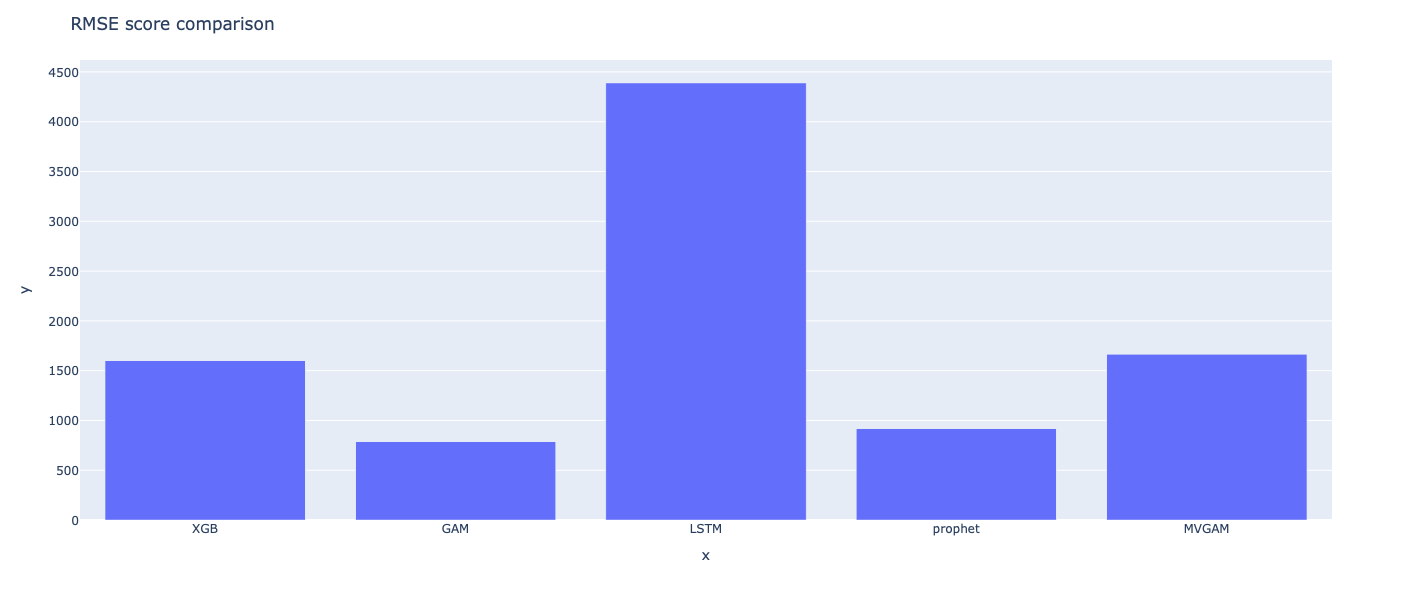

In [270]:
fig = px.bar(x=RMSE_dict.keys(), y=RMSE_dict.values())
fig.update_layout(height = 600, width=600)
fig.update_layout(
    title='RMSE score comparison'
)

# Review
### XGBoost:
##### - great ability to learn seasonal trends
##### - extremely fast to train and test
##### - parameter tuning is not very straight forward as the "n_estimators" and depth of tree can make a huge difference in prediction.
##### - doesn't learn exponential growths or natural growths
##### - some explainability

### GAM:
##### - great ability to learn seasonal trends
##### - extremely fast to train and test
##### - great explainability

### prophet:
##### - good at finding natural growth trends
##### - onderfitting and faces extrapolation issues as it tends to shoot in one direction
##### - perhaps experimenting with the parameters will give better fit control as it is a GAM model
##### - uncertainty value is provided and visualized by default

### MVGAM:
##### - great ability to learn seasonal trends
##### - very slow to train and test
##### - much lower interpretability compared to the other GAMs
##### - uncertainty value is provided and visualized by default
##### - more experimentation needed for more conclusive review

### LSTM:
##### - very slow to train and test
##### - has close to no ability to learn without a lag feature that has the most weights for learning. XGBoost, on the other hand, for instance relied heavily on "yesterday's price" in training, but in testing, it was deprived of it. Still, it was able to rely on the other variables it was shown.


# Summary
### In this project, I went back and fixed an XGBoost model that I previously used by eliminating data leakage. Then I used 4 other machine learning models and reviewed each one of them. The general additive models outperformed all the other models out of the box, or with very little modification. They all had explainability metrics. MVGAM is a very new model, and it is not yet optimized for large data. LSTM was given 100 lag features, and it would've performed better if lag feature of "Time-x" feature for previous datas were present, but that would've only made at best 100 predictions more robust. LSTM is only as good as it has remaining lag features in the pipeline, which is not even available for predictions far into the future, XGBoost from the traditional models performed decently, and showed a good ability for generalization, and it was somewhat explainable. 